# Imports

In [1]:
from pyscope import observatory
from pyscope import logger
import numpy as np
import matplotlib.pyplot as plt
import logging
import time
import os
import pathlib
import astropy.io.fits as fits
from IPython.display import display, clear_output

In [2]:
logger.setLevel("INFO")
logger.addHandler(logging.StreamHandler())

# Connect to observatory

In [3]:
obs = observatory.Observatory("c:\PythonDev\GitHubRepo\KnoxObservatoryConfig\knox.cfg")
obs.connect_all()
camera_center_x = obs.camera.CameraXSize/2
camera_center_y = obs.camera.CameraYSize/2

Using config file to initialize observatory: c:\PythonDev\GitHubRepo\KnoxObservatoryConfig\knox.cfg
Checking passed kwargs and overriding config file values
Camera connected


Turning cooler on


Focuser connected
Telescope connected


In [ ]:
# Set filter to V
filter_list = obs.filter_wheel.Names
print(f"Filter names are: {filter_list}")
# Get filter number for V
filter_number = filter_list.index("V")
print(f"Filter number for V is: {filter_number}")
print(f"Moving to filter {filter_number}...")
obs.filter_wheel.Position = filter_number

We will need to focus using TheSkyX. Home the focuser before running the autofocus routine.

Verify that Camera is connected and can take image.

In [60]:
obs.camera.StartExposure(1, True)

In [61]:
obs.camera.ImageReady

True

In [62]:
img = obs.camera.ImageArray

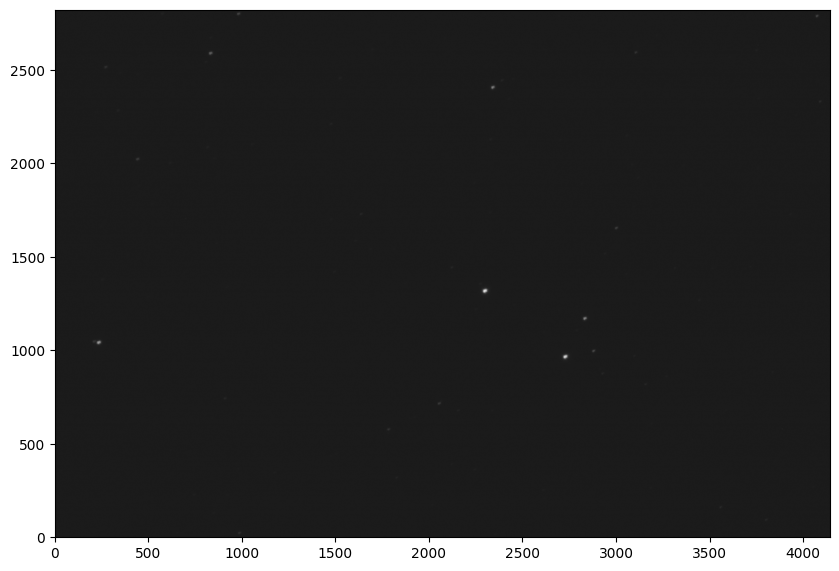

In [63]:
# Plot the image
# lognorm
from matplotlib.colors import LogNorm

plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray', origin='lower', norm=LogNorm(vmin=250))
plt.show()

Disconnect All

In [112]:
obs.disconnect_all()

Camera disconnected
Focuser disconnected
Telescope disconnected


True

## Choose and slew to target

In [44]:
# Slew to Rigel
target = "HIP23765"
obs.slew_to_coordinates(target, frame="TETE")

Slewing to RA hms_tuple(h=5.0, m=6.0, s=29.86244880000207) and Dec dms_tuple(d=35.0, m=33.0, s=45.04770000000747)
Turning on sidereal tracking...
Sidereal tracking is on.
Attempting to slew to coordinates...
Settling for 5.00 seconds...


True

In [100]:
# Slew to Rigel
target = "M1"
obs.slew_to_coordinates(target)

Slewing to RA hms_tuple(h=5.0, m=34.0, s=30.888000000003046) and Dec dms_tuple(d=22.0, m=0.0, s=52.92000000000456)
Turning on sidereal tracking...
Sidereal tracking is on.
Attempting to slew to coordinates...
Settling for 5.00 seconds...


True

In [101]:
# Move focus to 15200
obs.focuser.Move(15200)
while obs.focuser.IsMoving:
    time.sleep(0.1)

### Test recentering

Need to figure out platesolving on the observatory computer and how to interface that with pyscope, this may take too long to figure out for this weekend.

In [ ]:
obs.recenter(
    target,
    target_x_pixel=camera_center_x,
    target_y_pixel=camera_center_y,
    do_initial_slew=False,
)

# Take images across different focus positions

## Set up focus positions to test

In [19]:
best_focus = obs.focuser.Position
# best_focus = 17523
print(f"Best focus position is {best_focus}")
#max_focus = obs.focuser.MaxStep
max_focus = 30000
print(f"Max focus position is {max_focus}")
min_focus = 0

# Focus step = 256
focus_step = 1024

# Calculate minimum position greater than 0 given the focus step and the best focus position
min_focus = (best_focus % focus_step)
print(f"Min focus position is {min_focus}")

# Calculate maximum position less than max_focus given the focus step and the best focus position
max_focus = max_focus - (max_focus % focus_step)
print(f"Max focus position is {max_focus}")

# Create a list of focus positions
focus_positions = np.arange(min_focus, max_focus, focus_step)
print(f"Focus positions are {focus_positions}, there are {len(focus_positions)} positions")

# Add in 256 steps around the best focus position
focus_positions = np.concatenate((focus_positions, np.arange(best_focus-(256*6), best_focus+(256*7), 256)))
# Sort the list and remove duplicates
focus_positions = np.unique(focus_positions)
print(f"Focus positions are {focus_positions}, there are {len(focus_positions)} positions")

Best focus position is 15021
Max focus position is 30000
Min focus position is 685
Max focus position is 29696
Focus positions are [  685  1709  2733  3757  4781  5805  6829  7853  8877  9901 10925 11949
 12973 13997 15021 16045 17069 18093 19117 20141 21165 22189 23213 24237
 25261 26285 27309 28333 29357], there are 29 positions
Focus positions are [  685  1709  2733  3757  4781  5805  6829  7853  8877  9901 10925 11949
 12973 13485 13741 13997 14253 14509 14765 15021 15277 15533 15789 16045
 16301 16557 17069 18093 19117 20141 21165 22189 23213 24237 25261 26285
 27309 28333 29357], there are 39 positions


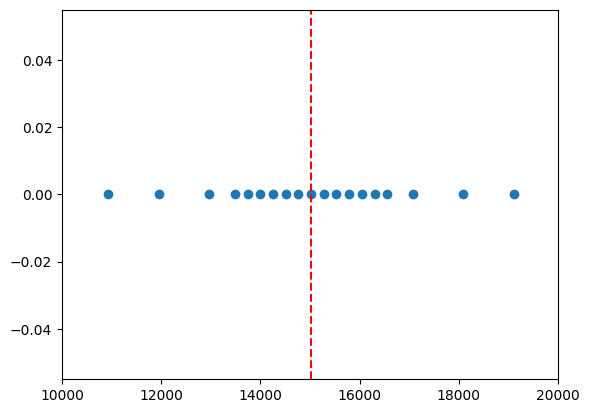

In [20]:
# Plot the focus positions on a scatter plot
plt.scatter(focus_positions, np.zeros(len(focus_positions)))
plt.xlim(10000,20000)
# Plot vertical line at best focus position
plt.axvline(x=best_focus, color='r', linestyle='--')
plt.show()

## Focus at minimum/best/maximum position to check exposure time

In [21]:
exp_time = 5
# Image save directory
save_dir = "focus_images"
# Make the save directory if it doesn't exist
pathlib.Path(save_dir).mkdir(parents=True, exist_ok=True)

In [22]:
def capture_focus_image(focus_position, exp_time=exp_time, filename_prefix="focus", binning=1):
    # # Set binning
    obs.camera.BinX = binning
    obs.camera.BinY = binning

    # # Start exposure
    obs.camera.StartExposure(exp_time, True)
    
    # Set up image base filename
    exp_time_str = str(exp_time).replace(".", "p")
    filename_base = f"{filename_prefix}_{focus_position}_{exp_time_str}s"
    # Check if file exists in save_dir
    i = 0
    filename = pathlib.Path(save_dir) / f"{filename_base}_{i}.fts"
    # print(f"Checking if {filename} exists...")
    # print(f"filename.exists() is {filename.exists()}")
    while filename.exists():
        # If file exists, add a number to the end of the filename
        i += 1
        # print(f"{filename} does exist")
        filename = pathlib.Path(save_dir) / f"{filename_base}_{i}.fts"
        # print(f"Checking if {filename} exists...")

    # Save latest image
    while not obs.camera.ImageReady:
        time.sleep(0.1)
    obs.save_last_image(filename, "Light")

    return filename

### Best focus position

In [80]:
current_focus = obs.focuser.Position

# Take an image of 5 seconds
img_file = capture_focus_image(current_focus, exp_time=3, filename_prefix="focusTest", binning=1)


In [81]:
camera_center_x = 2300
camera_center_y = 1300
# Plot center 256x256 pixels of image
img_center = fits.getdata(img_file)[camera_center_y-128:camera_center_y+128, camera_center_x-128:camera_center_x+128]

# Calculate the mean pixel value of the center 256x256 pixels
mean_pixel = np.mean(img_center)
print(f"Mean pixel value is {mean_pixel}")
# Find the 10 brightest pixels
brightest_pixels = np.sort(img_center.flatten())[-5:]
print(f"The 5 brightest pixels are {brightest_pixels}.")
# Find the number of pixels above 55000
bright_pixels = img_center[img_center > 55000]
print(f"There are {len(bright_pixels)} pixels above 55000.")


Mean pixel value is 484.9263916015625
The 5 brightest pixels are [35132 35136 35760 35788 35960].
There are 0 pixels above 55000.


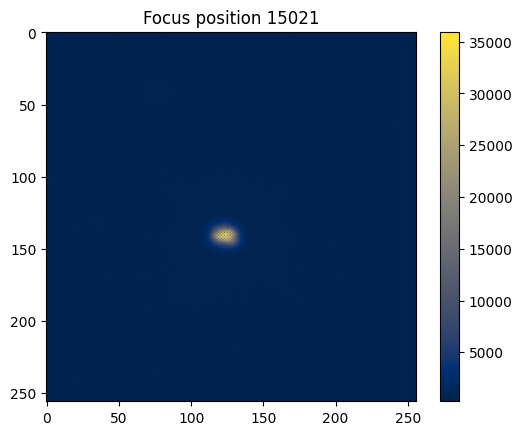

In [82]:
plt.imshow(img_center, cmap='cividis')
plt.title(f"Focus position {current_focus}")
plt.colorbar()
plt.show()

### Minimum focus position

Absolute mode is True
Mean pixel value is 423.34814453125
There are 10 pixels above 560


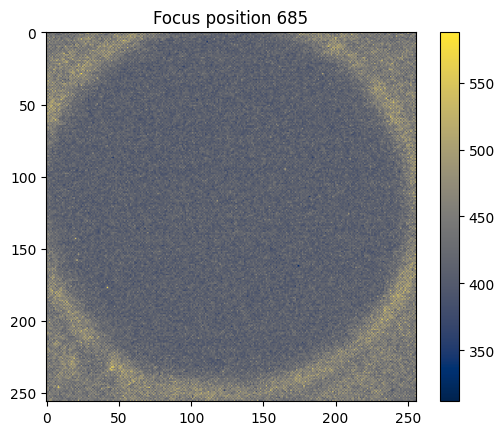

In [86]:
# Move to minimum focus position in list
# First check if we are in absolute mode
print(f"Absolute mode is {obs.focuser.Absolute}")
if not obs.focuser.Absolute:
    obs.focuser.Absolute = True
    print(f"Absolute mode is {obs.focuser.Absolute}")

# Move to minimum focus position in list
obs.focuser.Move(focus_positions[0])
while obs.focuser.IsMoving:
    #print(f"Focuser is moving to {focus_positions[0]}")
    time.sleep(0.1)
# Take an image of 5 seconds
img_file = capture_focus_image(focus_positions[0], exp_time=3, filename_prefix="focusTest", binning=1)
# Plot center 256x256 pixels of image
img_center = fits.getdata(img_file)[camera_center_y-128:camera_center_y+128, camera_center_x-128:camera_center_x+128]

# Calculate the mean pixel value of the center 256x256 pixels
mean_pixel = np.mean(img_center)
print(f"Mean pixel value is {mean_pixel}")
# Find the 10 brightest pixels
brightest_pixels = np.sort(img_center.flatten())[-10:]
print(f"There are 10 pixels above {brightest_pixels[0]}")
plt.imshow(img_center, cmap='cividis')
plt.title(f"Focus position {focus_positions[0]}")
plt.colorbar()
plt.show()

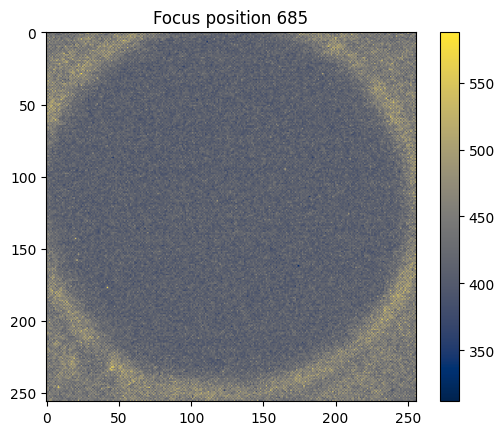

In [87]:
plt.imshow(img_center, cmap='cividis')
plt.title(f"Focus position {focus_positions[0]}")
plt.colorbar()
plt.show()

### Maximum focus position

Absolute mode is True
Mean pixel value is 433.07611083984375
There are 10 pixels above 560


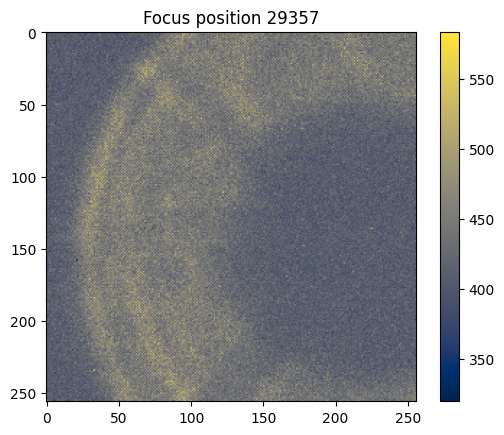

In [88]:
# Move to minimum focus position in list
# First check if we are in absolute mode
print(f"Absolute mode is {obs.focuser.Absolute}")
if not obs.focuser.Absolute:
    obs.focuser.Absolute = True
    print(f"Absolute mode is {obs.focuser.Absolute}")

# Move to minimum focus position in list
obs.focuser.Move(focus_positions[-1])
while obs.focuser.IsMoving:
    #print(f"Focuser is moving to {focus_positions[0]}")
    time.sleep(0.1)
# Take an image of 5 seconds
img_file = capture_focus_image(focus_positions[-1], exp_time=3, filename_prefix="focusTest", binning=1)
# Plot center 256x256 pixels of image
img_center = fits.getdata(img_file)[camera_center_y-128:camera_center_y+128, camera_center_x-128:camera_center_x+128]

# Calculate the mean pixel value of the center 256x256 pixels
mean_pixel = np.mean(img_center)
print(f"Mean pixel value is {mean_pixel}")
# Find the 10 brightest pixels
brightest_pixels = np.sort(img_center.flatten())[-10:]
print(f"There are 10 pixels above {brightest_pixels[0]}")
plt.imshow(img_center, cmap='cividis')
plt.title(f"Focus position {focus_positions[-1]}")
plt.colorbar()
plt.show()

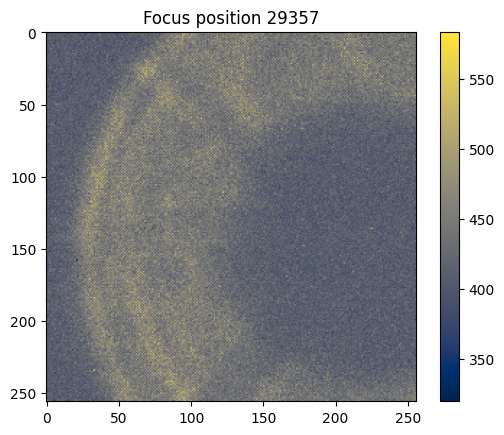

In [89]:
plt.imshow(img_center, cmap='cividis')
plt.title(f"Focus position {focus_positions[-1]}")
plt.colorbar()
plt.show()

## Take images at all different focus positions

In [92]:
# Set up varying exposure times, 6 seconds up to 10000 micron focus position 3 until 20000, then 6 seconds up to 30000
exp_times = np.empty(len(focus_positions))
for focus_position in focus_positions:
    if focus_position < 10000:
        exp_times[focus_positions == focus_position] = 6
    elif focus_position > 20000:
        exp_times[focus_positions == focus_position] = 6
    else:
        exp_times[focus_positions == focus_position] = 3
for i in range(len(focus_positions)):
    print(f"Focus position: {focus_positions[i]}, exp_time: {exp_times[i]}")

Focus position: 685, exp_time: 6.0
Focus position: 1709, exp_time: 6.0
Focus position: 2733, exp_time: 6.0
Focus position: 3757, exp_time: 6.0
Focus position: 4781, exp_time: 6.0
Focus position: 5805, exp_time: 6.0
Focus position: 6829, exp_time: 6.0
Focus position: 7853, exp_time: 6.0
Focus position: 8877, exp_time: 6.0
Focus position: 9901, exp_time: 6.0
Focus position: 10925, exp_time: 3.0
Focus position: 11949, exp_time: 3.0
Focus position: 12973, exp_time: 3.0
Focus position: 13485, exp_time: 3.0
Focus position: 13741, exp_time: 3.0
Focus position: 13997, exp_time: 3.0
Focus position: 14253, exp_time: 3.0
Focus position: 14509, exp_time: 3.0
Focus position: 14765, exp_time: 3.0
Focus position: 15021, exp_time: 3.0
Focus position: 15277, exp_time: 3.0
Focus position: 15533, exp_time: 3.0
Focus position: 15789, exp_time: 3.0
Focus position: 16045, exp_time: 3.0
Focus position: 16301, exp_time: 3.0
Focus position: 16557, exp_time: 3.0
Focus position: 17069, exp_time: 3.0
Focus positi

In [93]:
# Move focus to position 0
obs.focuser.Move(focus_positions[0])
while obs.focuser.IsMoving:
    time.sleep(0.1)

In [94]:
# Move to 256 steps
obs.focuser.Move(256)
while obs.focuser.IsMoving:
    time.sleep(0.1)

In [96]:
# Focus at each position
num_images = 4
focus_move_time = 15
img_download_time = 6
focus_image_time = exp_time + img_download_time

# Estimate total time required
total_time = (
    focus_move_time * len(focus_positions)
) + focus_image_time * num_images * len(focus_positions)
print(f"Estimated total time required is {total_time/60} minutes")

time_per_cycle = []

for focus_position in focus_positions:
    if time_per_cycle:
        print(f"Average time per cycle is {np.mean(time_per_cycle):.2f} seconds")
        est_time_remaining = np.mean(time_per_cycle) * (
            len(focus_positions) - np.where(focus_positions == focus_position)[0][0]
        )
        # Print time remaining in minutes and seconds
        print(
            f"Estimated time remaining is {est_time_remaining//60:.0f} min {est_time_remaining%60:.0f} sec"
        )
    start_time = time.time()
    print(f"Moving to focus position {focus_position}")

    print(
        f"This is position {np.where(focus_positions == focus_position)[0][0]+1} of {len(focus_positions)}"
    )
    obs.focuser.Move(focus_position)
    while obs.focuser.IsMoving:
        #print(f"Focuser is moving to {focus_positions[0]}")
        time.sleep(0.1)
    current_focus = obs.focuser.Position
    current_focus = focus_position
    print(f"Focus position is {current_focus}")
    print("========================================")

    current_exp_time = exp_times[focus_positions == focus_position]

    for i in range(num_images):
        img_file = capture_focus_image(current_focus, exp_time=current_exp_time, filename_prefix="focus", binning=1)
        print(f"Saved image {i} at focus position {current_focus}")

    end_time = time.time()
    time_per_cycle.append(end_time - start_time)

    # Clear cell output for next loop
    clear_output()

In [98]:
# Export time per cycle to a file
np.savetxt("time_per_cycle.txt", time_per_cycle)

In [99]:
time_per_cycle

[45.812811613082886,
 46.8670392036438,
 47.922600746154785,
 48.71472191810608,
 48.66837000846863,
 46.37673044204712,
 47.475918769836426,
 47.86139988899231,
 47.62826681137085,
 47.814709424972534,
 36.66993284225464,
 35.76189637184143,
 35.42367100715637,
 33.01124405860901,
 32.956425189971924,
 31.872793912887573,
 32.04783391952515,
 32.293970584869385,
 32.33753943443298,
 32.89465570449829,
 32.281527042388916,
 32.10457229614258,
 32.69475197792053,
 32.78887605667114,
 31.574421405792236,
 32.42794442176819,
 33.9847571849823,
 35.155654191970825,
 35.60331630706787,
 48.25940155982971,
 47.29528856277466,
 47.3070285320282,
 48.20084524154663,
 47.59011435508728,
 47.083359241485596,
 48.07305669784546,
 47.97140097618103,
 47.86191701889038,
 39.277955770492554]

In [106]:
current_focus = obs.focuser.Position
img_file = capture_focus_image(current_focus, exp_time=60, filename_prefix="Crab", binning=1)

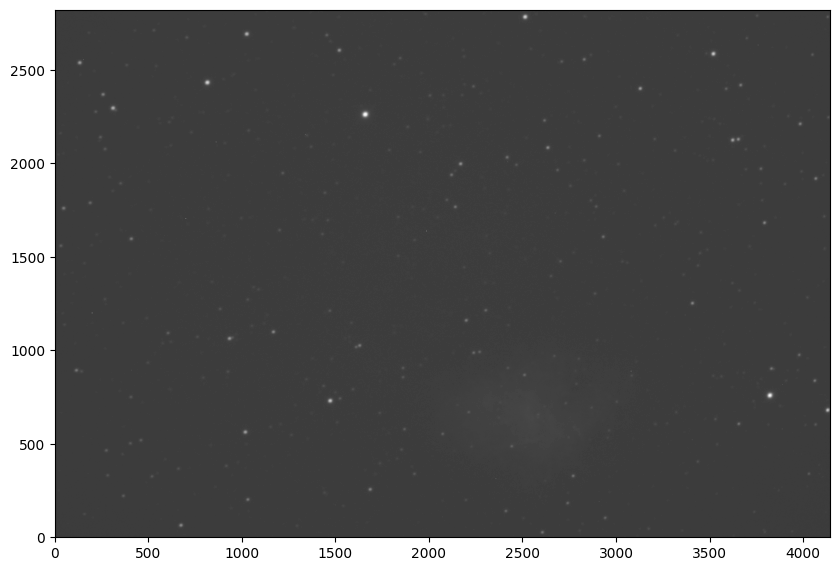

In [107]:
plt.figure(figsize=(10,10))
plt.imshow(fits.getdata(img_file), cmap='gray', origin='lower', norm=LogNorm(vmin=250))
plt.show()

In [108]:
# Park telescope
obs.telescope.Park()

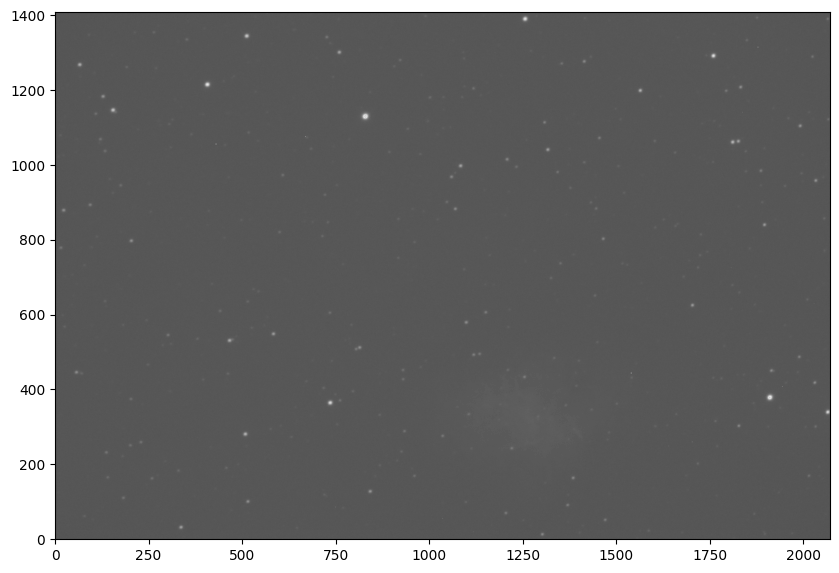

In [109]:
# Debayer image
img = fits.getdata(img_file)
bayer_pattern = "RGGB"



In [110]:
# Need 3 and 6 second darks (and maybe some 60s)
# Take 10 darks at each exposure time
dark_exp_times = [3, 6]
dark_num_images = 10
dark_save_dir = "dark_images"
# Make the save directory if it doesn't exist
pathlib.Path(dark_save_dir).mkdir(parents=True, exist_ok=True)

for exp_time in dark_exp_times:
    for i in range(dark_num_images):
        img_file = capture_focus_image(0, exp_time=exp_time, filename_prefix="dark", binning=1)
        print(f"Saved dark image {i} at focus position 0 and exposure time {exp_time}. Saved to {img_file}")

Saved dark image 0 at focus position 0 and exposure time 3. Saved to focus_images\dark_0_3s_0.fts
Saved dark image 1 at focus position 0 and exposure time 3. Saved to focus_images\dark_0_3s_1.fts
Saved dark image 2 at focus position 0 and exposure time 3. Saved to focus_images\dark_0_3s_2.fts
Saved dark image 3 at focus position 0 and exposure time 3. Saved to focus_images\dark_0_3s_3.fts
Saved dark image 4 at focus position 0 and exposure time 3. Saved to focus_images\dark_0_3s_4.fts
Saved dark image 5 at focus position 0 and exposure time 3. Saved to focus_images\dark_0_3s_5.fts
Saved dark image 6 at focus position 0 and exposure time 3. Saved to focus_images\dark_0_3s_6.fts
Saved dark image 7 at focus position 0 and exposure time 3. Saved to focus_images\dark_0_3s_7.fts
Saved dark image 8 at focus position 0 and exposure time 3. Saved to focus_images\dark_0_3s_8.fts
Saved dark image 9 at focus position 0 and exposure time 3. Saved to focus_images\dark_0_3s_9.fts
Saved dark image 0 a

In [111]:
# Take 60s darks
dark_exp_time = 60
dark_num_images = 10
for i in range(dark_num_images):
    img_file = capture_focus_image(0, exp_time=dark_exp_time, filename_prefix="dark", binning=1)
    print(f"Saved dark image {i} at focus position 0 and exposure time {dark_exp_time}. Saved to {img_file}")

Saved dark image 0 at focus position 0 and exposure time 60. Saved to focus_images\dark_0_60s_0.fts
Saved dark image 1 at focus position 0 and exposure time 60. Saved to focus_images\dark_0_60s_1.fts
Saved dark image 2 at focus position 0 and exposure time 60. Saved to focus_images\dark_0_60s_2.fts
Saved dark image 3 at focus position 0 and exposure time 60. Saved to focus_images\dark_0_60s_3.fts
Saved dark image 4 at focus position 0 and exposure time 60. Saved to focus_images\dark_0_60s_4.fts
Saved dark image 5 at focus position 0 and exposure time 60. Saved to focus_images\dark_0_60s_5.fts
Saved dark image 6 at focus position 0 and exposure time 60. Saved to focus_images\dark_0_60s_6.fts
Saved dark image 7 at focus position 0 and exposure time 60. Saved to focus_images\dark_0_60s_7.fts
Saved dark image 8 at focus position 0 and exposure time 60. Saved to focus_images\dark_0_60s_8.fts
Saved dark image 9 at focus position 0 and exposure time 60. Saved to focus_images\dark_0_60s_9.fts
